# Spiral Arm data preperation

In [1]:
import psycopg2

In [88]:
import pandas as pd

In [71]:
import matplotlib.pyplot as plt

In [166]:
import matplotlib.cm as cm

In [72]:
import astropy.coordinates as coord

In [73]:
import astropy.units as u

## Get data from database

In [16]:
cross_gaia_external = 'cross_gaia_ucac4'
external = 'ucac4'
distance = 'tgas_distance_mk_prior'

In [3]:
conn = psycopg2.connect(host='dev.ct9qpcsoabon.eu-west-3.rds.amazonaws.com', dbname='sa', user='icshih', password='0235sfxb')

In [4]:
cur = conn.cursor()

In [13]:
cur.execute('SELECT COUNT(*) FROM {} AS c, {} AS e WHERE c.ucac4id = e.ucac4id'.format(cross_gaia_external, external))

In [14]:
f = cur.fetchone()

In [15]:
print('There are {} objects from Gaia DR1 and UCAC4 catalogues'.format(f[0]))

There are 1319387 objects from Gaia DR1 and UCAC4 catalogues


In [17]:
cur.execute('SELECT COUNT(*) FROM {} AS c, {} AS d WHERE c.sourceid = d.gaia_source_id'.format(cross_gaia_external, distance))

In [18]:
g = cur.fetchone()

In [19]:
print('There are {} objects from Gaia DR1 with distance measurement'.format(g[0]))

There are 1323387 objects from Gaia DR1 with distance measurement


In [140]:
cur.execute('SELECT g.sourceid, g.l, g.b, g.ra, g.raerror, g.dec, g.decerror, g.pmra, g.pmraerror, g.pmdec, g.pmdecerror, g.parallax, g.parallaxerror, g.photgmeanmag, g.ucac4id, g.bmag, g.vmag, d.mode AS distance, d.distance_error FROM (SELECT c.*, e.bmag, e.vmag FROM {0} AS c, {1} AS e WHERE c.ucac4id = e.ucac4id) AS g, {2} AS d WHERE g.sourceid = d.gaia_source_id'.format(cross_gaia_external, external, distance))

In [141]:
name = list()
for i in range(len(cur.description)):
    name.append(cur.description[i][0])

In [142]:
df = pd.DataFrame(cur.fetchall())

In [143]:
df.columns = name

In [145]:
# Save to a csv file
df.to_csv('/Users/icshih/Desktop/gaia_for_spiral_arm.csv')

## Get data from file

In [89]:
df = pd.read_csv('/Users/icshih/Desktop/gaia_for_spiral_arm.csv')

In [210]:
 colr_ = plt.get_cmap('Blues')

In [260]:
def plot_sky_distribution(data_frame, is_save):
    gal = coord.SkyCoord(l=data_frame.l, b=data_frame.b, unit=(u.deg, u.deg), frame='galactic')
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.set_title('Object Distribution ({:,})'.format(len(data_frame)))
    ax.set_xlabel('Galactic Lon.')
    ax.set_ylabel('Galactic Lat.')
    norm = cm.colors.Normalize(vmin=df.parallaxerror.min(), vmax=df.parallaxerror.max())
    dist = ax.scatter(gal.l.wrap_at(180 * u.deg).radian, gal.b.radian, c=df.parallaxerror, cmap=colr_, norm=norm, s=0.1)
    cb = fig.colorbar(dist, orientation='vertical')
    ax.grid(True)
    if is_save:
        plt.savefig('/Users/icshih/Desktop/sky_distribution.png', format='png')

In [247]:
def plot_pm_distribution(data_frame, is_save):
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(211)
    ax1.set_title('pm ra (Gaia DR1)')
    ax1.set_xlabel('mas/y')
    ax1.set_xlim(-1000, 1000)
    ax1.set_yscale('log')
    ax1.hist(data_frame.pmra, bins=50)
    ax2 = fig.add_subplot(212)
    ax2.set_title('pm dec (Gaia DR1)')
    ax2.set_xlabel('mas/y')
    ax2.set_xlim(-1000, 1000)
    ax2.set_yscale('log')
    ax2.hist(data_frame.pmdec, bins=50)
    if is_save:
        plt.savefig('/Users/icshih/Desktop/proper_motion_distribution.png', format='png')

In [250]:
def plot_mag_distribution(data_frame, is_save):
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(221)
    ax1.set_title('G mean mag (Gaia DR1)')
    ax1.set_xlabel('mag')
    ax1.set_xlim(5, 15)
    ax1.set_yscale('log')
    ax1.hist(data_frame.photgmeanmag, bins=20)
    ax2 = fig.add_subplot(223)
    ax2.set_title('B mag (UCAC4/APASS)')
    ax2.set_xlabel('mag')
    ax2.set_xlim(5, 15)
    ax2.set_yscale('log')
    ax2.hist(data_frame.bmag.dropna(), bins=20)
    ax3 = fig.add_subplot(224)
    ax3.set_title('V mag (UCAC4/APASS)')
    ax3.set_xlabel('mag')
    ax3.set_xlim(5, 15)
    ax3.set_yscale('log')
    ax3.hist(data_frame.vmag.dropna(), bins=20)
    if is_save:
        plt.savefig('/Users/icshih/Desktop/magnitude_distribution.png', format='png')

In [261]:
def plot_parallax_distance_distribution(data_frame, is_save):
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(221)
    ax1.set_title('parallax (Gaia DR1)')
    ax1.set_xlabel('mas/y')
    ax1.set_xlim(-15, 200)
    ax1.set_yscale('log')
    ax1.hist(data_frame.parallax, bins=50)
    ax2 = fig.add_subplot(222)
    ax2.set_title('Distance/Mode')
    ax2.set_xlabel('pc')
    ax2.set_xlim(0, 10000)
    ax2.set_yscale('log')
    ax2.hist(data_frame.distance, bins=20)
    ax3 = fig.add_subplot(223)
    ax3.set_title('Parallax - Distance')
    ax3.set_xlabel('mas/y')
    ax3.set_xlim(-10, 5)
    ax3.set_ylabel('pc')
    norm = cm.colors.Normalize(vmin=data_frame.parallaxerror.min(), vmax=data_frame.parallaxerror.max())
    scat = ax3.scatter(data_frame.parallax, data_frame.distance, c=data_frame.parallaxerror, cmap=colr_, norm=norm, s=0.1)
    cb = fig.colorbar(scat, orientation='vertical')
    if is_save:
        plt.savefig('/Users/icshih/Desktop/parallax_distance_distribution.png', format='png')

In [214]:
def plot_pmra(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('pm ra (Gaia DR1)')
    ax.set_xlabel('mas/y')
    ax.set_xlim(-1000, 1000)
    ax.set_yscale('log')
    ax.hist(data_frame.pmra, bins=50)
    plt.show()

In [215]:
def plot_pmdec(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('pm dec (Gaia DR1)')
    ax.set_xlabel('mas/y')
    ax.set_xlim(-1000, 1000)
    ax.set_yscale('log')
    ax.hist(data_frame.pmdec, bins=50)
    plt.show()

In [227]:
def plot_gmag(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('G mean mag (Gaia DR1)')
    ax.set_xlabel('mag')
    ax.set_xlim(5, 15)
    ax.set_yscale('log')
    ax.hist(data_frame.photgmeanmag, bins=20)
    plt.show()

In [217]:
def plot_bmag(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('B mag (UCAC4/APASS)')
    ax.set_xlabel('mag')
    ax.set_xlim(5, 15)
    ax.set_yscale('log')
    ax.hist(data_frame.bmag.dropna(), bins=20)
    plt.show()

In [218]:
def plot_vmag(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('V mag (UCAC4/APASS)')
    ax.set_xlabel('mag')
    ax.set_xlim(5, 15)
    ax.set_yscale('log')
    ax.hist(data_frame.vmag.dropna(), bins=20)
    plt.show()

In [219]:
def plot_parallax(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('parallax (Gaia DR1)')
    ax.set_xlabel('mas/y')
    ax.set_xlim(-15, 200)
    ax.set_yscale('log')
    ax.hist(data_frame.parallax, bins=50)
    plt.show()

In [220]:
def plot_distance(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Distance/Mode')
    ax.set_xlabel('pc')
    ax.set_xlim(0, 10000)
    ax.set_yscale('log')
    ax.hist(data_frame.distance, bins=20)
    plt.show()

In [221]:
def plot_parallax_distance(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Parallax - Distance')
    ax.set_xlabel('mas/y')
    ax.set_ylabel('pc')
    norm = cm.colors.Normalize(vmin=data_frame.distance_error.min(), vmax=data_frame.distance_error.max())
    scat = ax.scatter(data_frame.parallax, data_frame.distance, c=data_frame.distance_error, cmap=colr_, norm=norm, s=0.1)
    cb = fig.colorbar(scat, orientation='vertical')
    plt.show()

In [258]:
def plot_parallax_distance_zoom_in(data_frame):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Parallax - Distance')
    ax.set_xlabel('mas/y')
    ax.set_xlim(-10, 5)
    ax.set_ylabel('pc')
    norm = cm.colors.Normalize(vmin=data_frame.parallaxerror.min(), vmax=data_frame.parallaxerror.max())
    scat = ax.scatter(data_frame.parallax, data_frame.distance, c=data_frame.parallaxerror, cmap=colr_, norm=norm, s=0.1)
    cb = fig.colorbar(scat, orientation='vertical')
    plt.show()

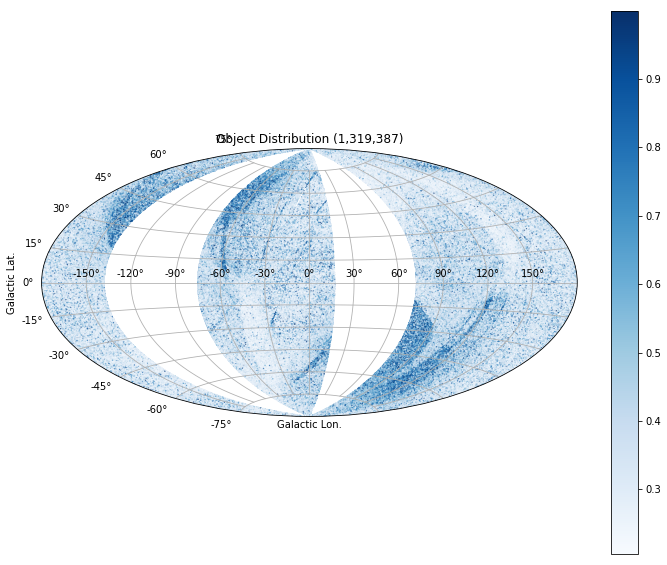

In [264]:
plot_sky_distribution(df, True)
plt.show()

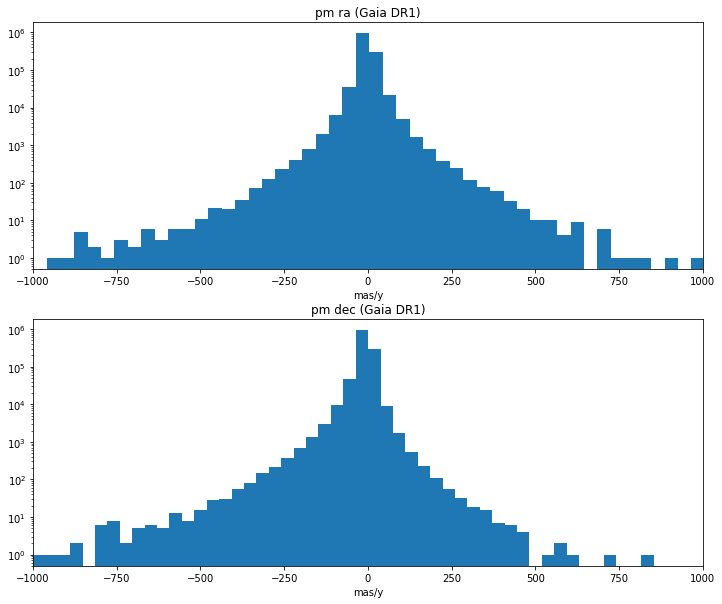

In [265]:
plot_pm_distribution(df, True)
plt.show()

In [254]:
plot_mag_distribution(df, True)
plt.show()

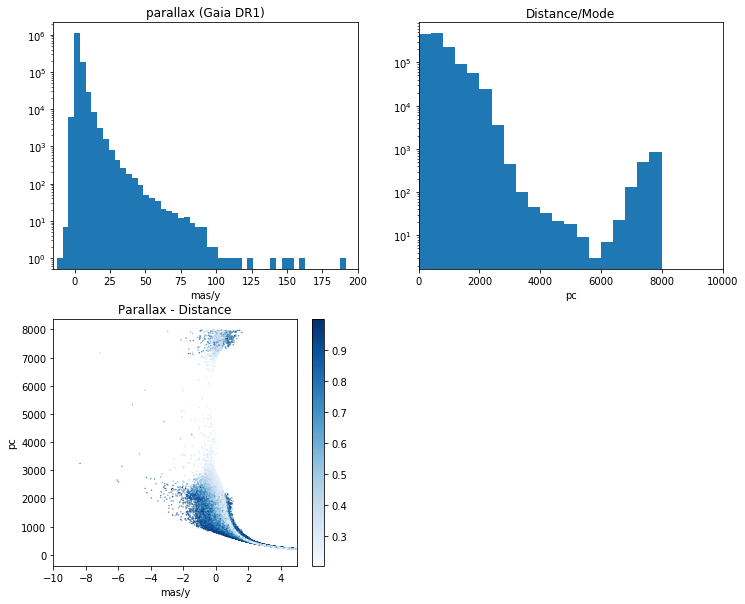

In [263]:
plot_parallax_distance_distribution(df, True)
plt.show()

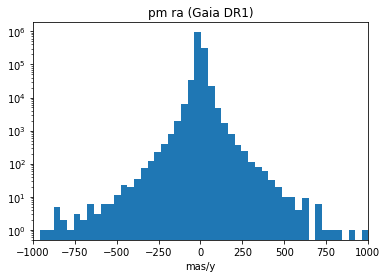

In [223]:
plot_pmra(df)

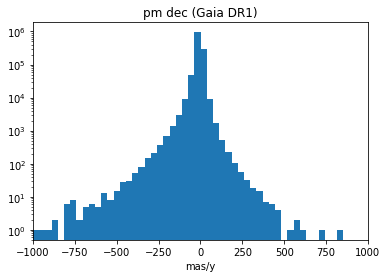

In [225]:
plot_pmdec(df)

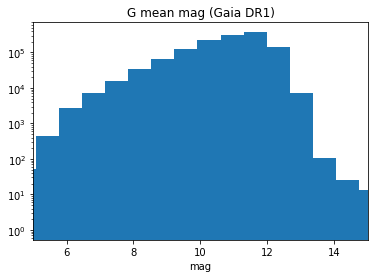

In [229]:
plot_gmag(df)

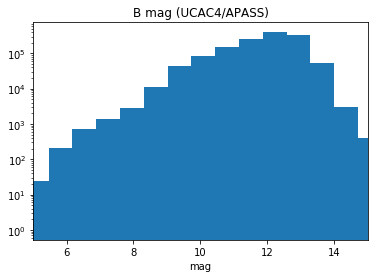

In [230]:
plot_bmag(df)

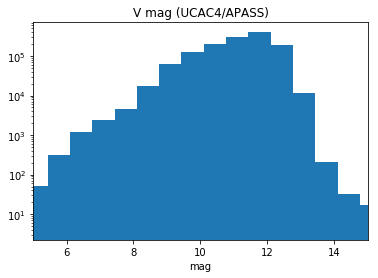

In [231]:
plot_vmag(df)

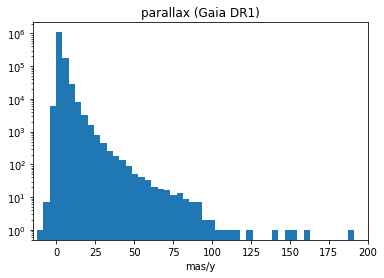

In [232]:
plot_parallax(df)

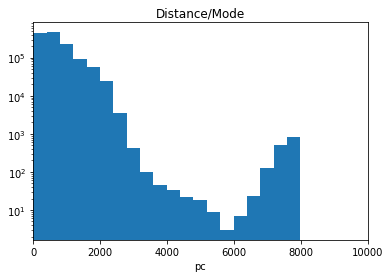

In [233]:
plot_distance(df)

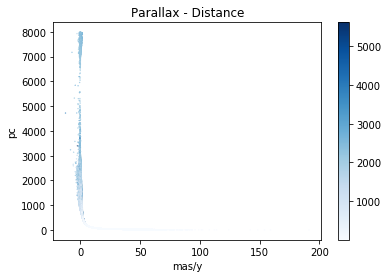

In [234]:
plot_parallax_distance(df)

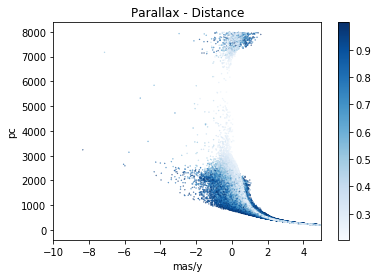

In [262]:
plot_parallax_distance_zoom_in(df)

In [150]:
conn.close()